In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import tensorflow as tf
from glob import glob
import sys
import sklearn.metrics as metrics

In [2]:
# This is needed to display the images.
%matplotlib inline

In [3]:
# What model to download.
MODEL_NAME = 'ssd_mobilenet_v1_coco_11_06_2017'
MODEL_FILE = MODEL_NAME + '.tar.gz'
DOWNLOAD_BASE = 'http://download.tensorflow.org/models/object_detection/'

# Path to frozen detection graph. This is the actual model that is used for the object detection.
model_path = "./"
PATH_TO_CKPT = model_path + MODEL_NAME + '/frozen_inference_graph.pb'


def download_model():
    import six.moves.urllib as urllib
    import tarfile

    opener = urllib.request.URLopener()
    opener.retrieve(DOWNLOAD_BASE + MODEL_FILE, MODEL_FILE)
    tar_file = tarfile.open(MODEL_FILE)
    for file in tar_file.getmembers():
        file_name = os.path.basename(file.name)
        if 'frozen_inference_graph.pb' in file_name:
            tar_file.extract(file, os.getcwd())

In [4]:
import os
import numpy as np
from PIL import Image

# Path to your dataset folder
DATASET_PATH = r"C:\Users\Admin\Downloads\traffic dataset"

def load_image_paths(dataset_path):
    """
    Loads all image file paths from the dataset folder.
    """
    image_paths = []
    for root, dirs, files in os.walk(dataset_path):
        for file in files:
            if file.lower().endswith(('.png', '.jpg', '.jpeg')):
                image_paths.append(os.path.join(root, file))
    return image_paths

def load_image(image_path):
    """
    Loads an image from the given path and converts it to a numpy array.
    """
    try:
        image = Image.open(image_path).convert('RGB')  # Ensure 3-channel RGB
        image_np = np.asarray(image)
        return image_np
    except Exception as e:
        print(f"Failed to load image {image_path}: {e}")
        return None

class TLClassifier:
    def __init__(self, dataset_path):
        """
        Initialize the traffic light classifier with a dataset path.
        """
        if not os.path.exists(dataset_path):
            raise FileNotFoundError(f"Dataset folder not found at {dataset_path}")
        self.dataset_path = dataset_path
        self.image_paths = load_image_paths(dataset_path)
        if not self.image_paths:
            raise FileNotFoundError(f"No images found in the dataset folder: {dataset_path}")
        print(f"Initialized TLClassifier with {len(self.image_paths)} images.")

    def process_images(self):
        """
        Processes all images in the dataset and performs basic analysis.
        """
        for i, image_path in enumerate(self.image_paths):
            image_np = load_image(image_path)
            if image_np is not None:
                print(f"Processed image {i + 1}/{len(self.image_paths)}: {image_path}")
                print(f"Image shape: {image_np.shape}")
            else:
                print(f"Skipping image {i + 1}/{len(self.image_paths)} due to load failure.")

# Initialize the TLClassifier with the path to your dataset
tlc = TLClassifier(dataset_path=DATASET_PATH)

# Process all images
#tlc.process_images()

Initialized TLClassifier with 80669 images.


In [5]:
import tensorflow.compat.v1 as tf
import warnings
tf.disable_v2_behavior()  # Disable TensorFlow 2.x behavior


Instructions for updating:
non-resource variables are not supported in the long term


In [6]:
def crop_roi_image(image_np, sel_box):
    im_height, im_width, _ = image_np.shape
    (left, right, top, bottom) = (sel_box[1] * im_width, sel_box[3] * im_width,
                                  sel_box[0] * im_height, sel_box[2] * im_height)
    cropped_image = image_np[int(top):int(bottom), int(left):int(right), :]
    return cropped_image

Found 4060 image file(s). Selecting the first one.
Test file: C:\Users\Admin\Downloads\traffic dataset\archive (3)\daySequence1\daySequence1\frames\daySequence1--00000.jpg


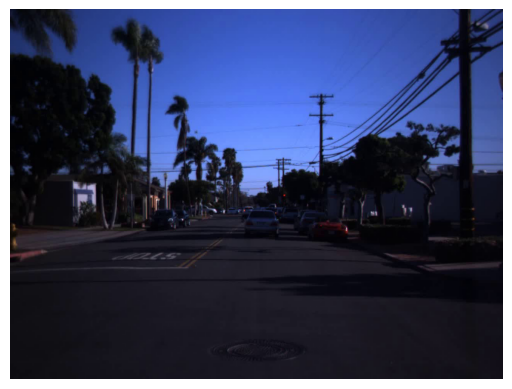

In [7]:
import os
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

# Specify the base directory
base_directory = r"C:\Users\Admin\Downloads\traffic dataset\archive (3)\daySequence1"

# Recursively search for image files
def find_image_files(directory):
    image_extensions = (".jpg", ".jpeg", ".png", ".bmp")  # Common image extensions
    for root, _, files in os.walk(directory):
        for file in files:
            if file.lower().endswith(image_extensions):
                yield os.path.join(root, file)

# Find the first image file
image_files = list(find_image_files(base_directory))
if not image_files:
    print("No image files found in the directory.")
else:
    print(f"Found {len(image_files)} image file(s). Selecting the first one.")
    test_file = image_files[0]
    print(f"Test file: {test_file}")

    # Open and display the selected image
    try:
        im = Image.open(test_file)
        image_np = np.asarray(im)
        plt.imshow(image_np)
        plt.axis("off")
        plt.show()
    except Exception as e:
        print("Error opening the image:", e)

In [8]:
from pathlib import Path
import tensorflow.keras
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.applications.vgg16 import VGG16,preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img, img_to_array
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, Input, Flatten, Activation
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
from tensorflow.keras.callbacks import Callback, EarlyStopping
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import confusion_matrix
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications.inception_v3 import preprocess_input
from tensorflow.keras.preprocessing import image

In [9]:
IMAGE_SIZE = [224, 224]

In [10]:
inception = InceptionV3(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)

In [11]:
for layer in inception.layers:
    layer.trainable = False

In [12]:
x = Flatten()(inception.output)

In [13]:
train_path = r"C:\Users\Admin\Downloads\traffic dataset\cropped_lisa_1\train_1"
valid_path = r"C:\Users\Admin\Downloads\traffic dataset\cropped_lisa_1\val_1"

In [14]:
from glob import glob

folders = glob(train_path + '/*')

In [15]:
prediction = Dense(len(folders), activation='softmax')(x)

In [16]:
model = Model(inputs=inception.input, outputs=prediction)

In [17]:
model.compile(
  loss='categorical_crossentropy',
  optimizer='adam',
  metrics=['accuracy']
)

In [18]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale = 1./255,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

test_datagen = ImageDataGenerator(rescale = 1./255)

In [19]:
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define the correct path to the training dataset
train_path = "C:/Users/Admin/Downloads/traffic dataset/cropped_lisa_1/train_1"

# Check if the training path exists
if not os.path.exists(train_path):
    raise FileNotFoundError(f"Training path not found: {train_path}")

# Initialize the ImageDataGenerator
train_datagen = ImageDataGenerator(rescale=1./255)

# Create the training set
training_set = train_datagen.flow_from_directory(
    train_path,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

# Print confirmation of successful initialization
print("Training set successfully created.")

Found 32797 images belonging to 7 classes.
Training set successfully created.


In [20]:
val_set = test_datagen.flow_from_directory(valid_path,
                                            target_size = (224, 224),
                                            batch_size = 32,
                                            class_mode = 'categorical',
                                            shuffle = False)

Found 3737 images belonging to 7 classes.


In [21]:
print(training_set.class_indices)

{'go': 0, 'goForward': 1, 'goLeft': 2, 'stop': 3, 'stopLeft': 4, 'warning': 5, 'warningLeft': 6}


In [22]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define data generators for training and validation
train_datagen = ImageDataGenerator(
    rescale=1.0 / 255,  # Normalize pixel values
    shear_range=0.2,    # Apply shear transformations
    zoom_range=0.2,     # Apply zoom transformations
    horizontal_flip=True  # Flip images horizontally
)

val_datagen = ImageDataGenerator(
    rescale=1.0 / 255  # Normalize pixel values (no augmentation for validation data)
)

# Load the training set
training_set = train_datagen.flow_from_directory(
    r"C:\Users\Admin\Downloads\traffic dataset\cropped_lisa_1\train_1",  # Path to training data
    target_size=(64, 64),  # Resize images to 64x64
    batch_size=32,
    class_mode='binary'  # Use 'binary' for two classes, 'categorical' for multi-class
)

# Load the validation set
val_set = val_datagen.flow_from_directory(
    r"C:\Users\Admin\Downloads\traffic dataset\cropped_lisa_1\val_1",  # Path to validation data
    target_size=(64, 64),  # Resize images to 64x64
    batch_size=32,
    class_mode='binary'
)

Found 32797 images belonging to 7 classes.
Found 3737 images belonging to 7 classes.


In [23]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(rescale=1./255)
training_set = datagen.flow_from_directory(
    r"C:\Users\Admin\Downloads\traffic dataset\archive (3)",  # Update path here
    target_size=(64, 64),
    batch_size=32,
    class_mode='binary'
)
print(training_set.class_indices)

Found 44075 images belonging to 8 classes.
{'daySequence1': 0, 'daySequence2': 1, 'dayTrain': 2, 'nightSequence1': 3, 'nightSequence2': 4, 'nightTrain': 5, 'sample-dayClip6': 6, 'sample-nightClip1': 7}


In [1]:
import os
import tensorflow as tf
import warnings
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler, ModelCheckpoint

# Suppress TensorFlow warnings & logs
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'  # 0 = all messages, 1 = INFO, 2 = WARNING, 3 = ERROR
warnings.filterwarnings("ignore", category=UserWarning)  # Suppress Python UserWarnings

# ✅ Ensure Eager Execution is Enabled
tf.config.run_functions_eagerly(True)

# Paths
train_path = r"C:\Users\Admin\Downloads\traffic dataset\cropped_lisa_1\train_1"
val_path = r"C:\Users\Admin\Downloads\traffic dataset\cropped_lisa_1\val_1"

# ✅ Data Preprocessing
train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)

training_set = train_datagen.flow_from_directory(
    train_path,
    target_size=(64, 64),
    batch_size=32,
    class_mode='categorical'
)

val_set = val_datagen.flow_from_directory(
    val_path,
    target_size=(64, 64),
    batch_size=32,
    class_mode='categorical'
)

# ✅ Model Architecture
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(64, 64, 3)),
    MaxPooling2D(pool_size=(2, 2)),

    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),

    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),

    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(7, activation='softmax')  # Assuming 7 classes
])

# ✅ Compile Model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# ✅ Learning Rate Scheduler
def lr_schedule(epoch, lr):
    return lr * 0.95 if epoch > 5 else lr  # Reduce LR after 5 epochs

lr_scheduler = LearningRateScheduler(lr_schedule)
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
checkpoint = ModelCheckpoint('best_model.keras', monitor='val_loss', save_best_only=True, verbose=1)

# ✅ Train Model (Fixing steps_per_epoch)
history = model.fit(
    training_set,
    validation_data=val_set,
    epochs=50,
    steps_per_epoch=len(training_set),  # Fix: Use len() instead of .samples
    validation_steps=len(val_set),  # Fix: Use len() instead of .samples
    callbacks=[lr_scheduler, early_stopping, checkpoint],
    verbose=1
)

# ✅ Save Model
model.save('final_model.keras')

print("🎯 Model training completed successfully!")

Found 32797 images belonging to 7 classes.
Found 3737 images belonging to 7 classes.
Epoch 1/50
1025/1025 ━━━━━━━━━━━━━━━━━━━━ 0s 590ms/step - accuracy: 0.8972 - loss: 0.3434
Epoch 1: val_loss improved from inf to 0.44321, saving model to best_model.keras
1025/1025 ━━━━━━━━━━━━━━━━━━━━ 664s 647ms/step - accuracy: 0.8972 - loss: 0.3433 - val_accuracy: 0.9106 - val_loss: 0.4432 - learning_rate: 0.0010
Epoch 2/50
1025/1025 ━━━━━━━━━━━━━━━━━━━━ 0s 393ms/step - accuracy: 0.9690 - loss: 0.0931
Epoch 2: val_loss improved from 0.44321 to 0.21844, saving model to best_model.keras
1025/1025 ━━━━━━━━━━━━━━━━━━━━ 477s 447ms/step - accuracy: 0.9690 - loss: 0.0931 - val_accuracy: 0.9280 - val_loss: 0.2184 - learning_rate: 0.0010
Epoch 3/50
1025/1025 ━━━━━━━━━━━━━━━━━━━━ 0s 467ms/step - accuracy: 0.9797 - loss: 0.0604
Epoch 3: val_loss improved from 0.21844 to 0.19697, saving model to best_model.keras
1025/1025 ━━━━━━━━━━━━━━━━━━━━ 490s 478ms/step - accuracy: 0.9797 - loss: 0.0604 - val_accuracy: 0.9

In [2]:
# Save model in Keras format (.keras)
model.save("traffic_detection_model.keras")
print("Model saved successfully as traffic_detection_model.keras")

# Save model in HDF5 format (.h5)
model.save("traffic_detection_model.h5")
print("Model saved successfully as traffic_detection_model.h5")

Model saved successfully as traffic_detection_model.keras
Model saved successfully as traffic_detection_model.h5


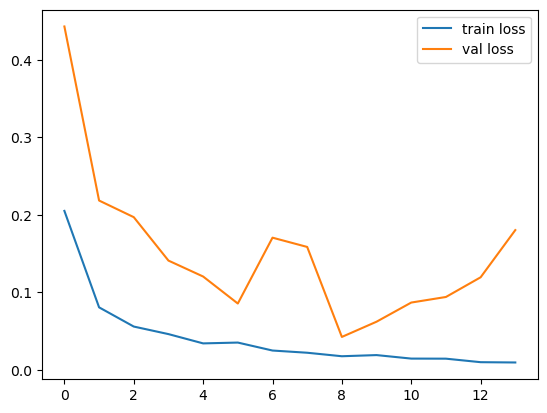

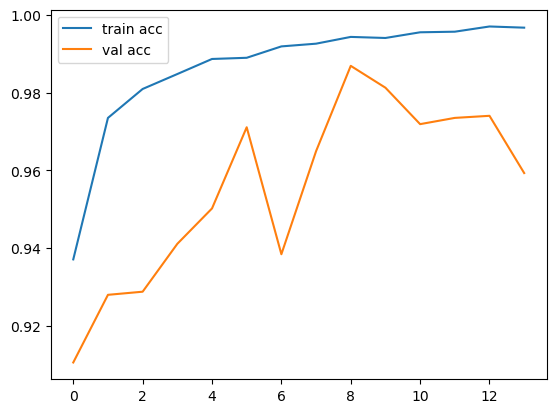

<Figure size 640x480 with 0 Axes>

In [3]:
import matplotlib.pyplot as plt  # Importing matplotlib for plotting

# Plot the loss
plt.plot(history.history['loss'], label='train loss')  # Use 'history' instead of 'r' if that's the variable name
plt.plot(history.history['val_loss'], label='val loss')
plt.legend()
plt.show()
plt.savefig('LossVal_loss.png')  # Save with the correct file extension (.png or other)

# Plot the accuracy
plt.plot(history.history['accuracy'], label='train acc')  # Update 'acc' to 'accuracy' if using modern Keras
plt.plot(history.history['val_accuracy'], label='val acc')  # Update 'val_acc' to 'val_accuracy'
plt.legend()
plt.show()
plt.savefig('AccVal_acc.png')

In [4]:
from sklearn.metrics import accuracy_score,classification_report,confusion_matrix
import numpy as np

In [5]:
import sys
import numpy as np

# Ensure val_set is defined and properly initialized
# Example: Assuming val_set is a DirectoryIterator from flow_from_directory
# val_set should already be initialized before calling this function.

batch_size = 32  # Set the batch size used in your data generator

# Function to get true and predicted labels
def true_and_predicted_labels(dataset, num_classes=7):
    num_samples = dataset.samples  # Total number of samples in the dataset
    labels = np.zeros((num_samples, num_classes))  # Placeholder for true labels
    preds = np.zeros_like(labels)  # Placeholder for predicted labels

    for i in range(len(dataset)):
        sys.stdout.write(f"Evaluating batch {i + 1}/{len(dataset)}\r")
        sys.stdout.flush()

        batch = dataset[i]
        batch_images = batch[0]  # Images from the batch
        batch_labels = batch[1]  # True labels from the batch

        batch_preds = model.predict(batch_images)  # Predicted labels

        # Compute indices for the current batch
        start = i * batch_size
        end = start + batch_images.shape[0]

        # Assign labels and predictions to their respective arrays
        labels[start:end] = batch_labels
        preds[start:end] = batch_preds

    return labels, preds

# Call the function to get the true and predicted labels
val_labels, val_preds = true_and_predicted_labels(val_set)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/s

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step


In [6]:
a = val_preds
idx = np.argmax(a, axis=-1)
a = np.zeros( a.shape )
a[ np.arange(a.shape[0]), idx] = 1

In [7]:
from sklearn.metrics import classification_report

# Assuming 'a' contains your predicted labels
print(classification_report(val_labels, a))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1372
           1       1.00      0.95      0.98        21
           2       0.96      0.97      0.97       109
           3       0.99      0.99      0.99      1777
           4       0.94      0.94      0.94       345
           5       1.00      1.00      1.00       108
           6       1.00      1.00      1.00         5

   micro avg       0.99      0.99      0.99      3737
   macro avg       0.98      0.98      0.98      3737
weighted avg       0.99      0.99      0.99      3737
 samples avg       0.99      0.99      0.99      3737



In [8]:
from sklearn.metrics import confusion_matrix

# Assuming 'val_labels' and 'a' are the true and predicted labels
print(confusion_matrix(val_labels.argmax(axis=1), a.argmax(axis=1)))

[[1366    0    4    1    1    0    0]
 [   1   20    0    0    0    0    0]
 [   3    0  106    0    0    0    0]
 [   0    0    0 1758   19    0    0]
 [   0    0    0   20  325    0    0]
 [   0    0    0    0    0  108    0]
 [   0    0    0    0    0    0    5]]


<Axes: >

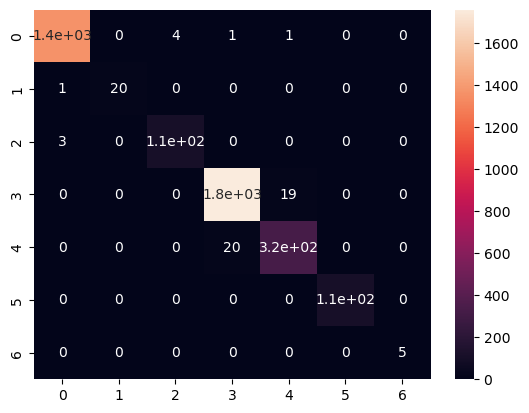

In [9]:
import seaborn as sns
cf_matrix = confusion_matrix(val_labels.argmax(axis=1), a.argmax(axis=1))
sns.heatmap(cf_matrix, annot=True)

In [10]:
from tensorflow.keras.preprocessing import image
import numpy as np
from tensorflow.keras.models import load_model

# ✅ Load the trained model
model = load_model('final_model.keras')  # Ensure this is the correct trained model

# ✅ Load and preprocess the image
img_path = r"C:\Users\Admin\Downloads\traffic dataset\archive (3)\sample-dayClip6\sample-dayClip6\frames\dayClip6--00458.jpg"
img = image.load_img(img_path, target_size=(64, 64))  # ✅ Resize to 64x64 (same as training size)
img_array = image.img_to_array(img)  # Convert to numpy array
img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
img_array = img_array / 255.0  # ✅ Rescale to match training preprocessing

# ✅ Make prediction
predictions = model.predict(img_array)

# ✅ Output prediction results
print("Raw Predictions:", predictions)
predicted_class = np.argmax(predictions, axis=1)  # Get class index with highest probability
print("Predicted Class:", predicted_class)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
Raw Predictions: [[2.2908206e-01 7.8571932e-12 7.7091748e-01 4.7077037e-07 8.2849141e-09
  2.4366489e-10 3.0102625e-16]]
Predicted Class: [2]


In [11]:
all_class_names = training_set.class_indices
all_class_names

{'go': 0,
 'goForward': 1,
 'goLeft': 2,
 'stop': 3,
 'stopLeft': 4,
 'warning': 5,
 'warningLeft': 6}

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
Class ID 920 not found in the all_class_names dictionary.


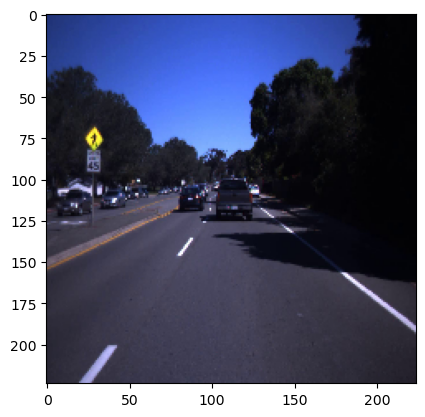

In [12]:
import numpy as np
import matplotlib.pyplot as plt
from keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input

# Correct image path
img_path = r"C:\Users\Admin\Downloads\traffic dataset\archive (3)\sample-dayClip6\sample-dayClip6\frames\dayClip6--00458.jpg"  # Replace with the actual image

# Load and preprocess the image
img = image.load_img(img_path, target_size=(224, 224))  # Resize image to 224x224
img_array = image.img_to_array(img)  # Convert to numpy array
img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
img_array = preprocess_input(img_array)  # Preprocess for VGG16

# Load the model (use your trained model if needed)
model = VGG16(weights='imagenet')

# Make prediction
predictions = model.predict(img_array)

# Assuming 'all_class_names' is a dictionary with the class names
all_class_names = {
    0: 'Class_0',
    1: 'Class_1',
    # Add more classes as per your dataset
}

# Get the index of the maximum value in predictions
pos_pred = predictions.argmax()

# Check if the predicted class ID exists in the all_class_names dictionary
if pos_pred in all_class_names:
    # Get the class names and IDs
    key_list = list(all_class_names.keys())
    val_list = list(all_class_names.values())

    # Find the position of the predicted class ID
    position = val_list.index(all_class_names[pos_pred])

    # Print the predicted class name
    print("Predicted Class:", key_list[position])
else:
    print(f"Class ID {pos_pred} not found in the all_class_names dictionary.")

# Display the image
plt.imshow(img)
plt.show()